In [1]:
""" 
Author: maxwell.cook@colorado.edu
"""

import os, sys, gc, time
import geopandas as gpd
import rasterio as rio
import rioxarray as rxr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import to_rgba

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# Load the VIIRS active fire detections gridded data
fp = os.path.join(projdir,f'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_aspenfires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)

# add lat/lon coordinates
df = grid.copy().to_crs(4326)
df['grid_x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['grid_y'] = df.geometry.centroid.y 
df = df[['grid_index','grid_x','grid_y']]
grid = grid.merge(df, on='grid_index', how='inner')

grid.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_first',
       'day_max_frp', 'dt_max_frp', 'first_obs_date', 'last_obs_date',
       't4_max', 't4_mean', 't5_max', 't5_mean', 'day_count', 'night_count',
       'frp_max_day', 'frp_max_night', 'frp_csum_day', 'frp_csum_night',
       'frp_mean_day', 'frp_mean_night', 'frp_p90_day', 'frp_p90_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'grid_x', 'grid_y'],
      dtype='object')

In [3]:
print(f"Dropping [{grid.duplicated(subset=['grid_index']).sum()}] duplicate grids.")
grid = grid.drop_duplicates(subset=['grid_index'], keep='first')

Dropping [726] duplicate grids.


In [4]:
# check on fractional overlap distribution
print(grid['overlap'].describe())
print("\n")
n_small = grid[grid['overlap'] < 0.05]['grid_index'].count() # less than 5% spatial overlap
print(f"There are [{n_small} ({round(n_small/len(grid)*100,2)}%)] girds with < 10% fractional overlap.")
grid = grid[grid['overlap'] >= 0.05] # remove these observations

count    48780.000000
mean         2.079077
std          2.033457
min          0.000002
25%          0.614063
50%          1.526049
75%          2.860410
max         24.806286
Name: overlap, dtype: float64


There are [1950 (4.0%)] girds with < 10% fractional overlap.


In [5]:
print(f"There are [{len(grid['Fire_ID'].unique())}] fire events in the Southern Rockies (2018-2023)")
print(f"\tWith {len(grid)} gridcells.")

There are [56] fire events in the Southern Rockies (2018-2023)
	With 46830 gridcells.


In [6]:
bounds = grid.total_bounds # for cropping the raster data

# USFS TreeMap (2016) Summaries

From Earth Engine, the forest type percent cover for each gridcell was calculated. From this, we also gathered the "all forest" percent. Then, within a mask for each species, the TreeMap metrics (e.g., BALIVE) were summarized. Finally, within each species mask the Sentinel-2 LAI and MNDWI averages were gathered.

In [7]:
# Load the summary table (from GEE reductions)
fp = os.path.join(projdir,'data/earth-engine/exports/treemap/gridstats_fortypcd.csv')
fortypcd = pd.read_csv(fp)
fortypcd.drop(columns=['system:index','.geo'], inplace=True) # drop the GEE id and .geo columns

# unpack histogram dictionary into columns
def parse_histogram(hist_str):
    # Convert float or NaN to string, then parse
    if isinstance(hist_str, float) or pd.isna(hist_str):
        hist_str = str(int(hist_str)) if not pd.isna(hist_str) else ""
    kv_pairs = hist_str.split(', ')  # Split the key-value pairs
    # Convert key-value pairs to a dictionary
    return {int(kv.split(':')[0]): float(kv.split(':')[1]) for kv in kv_pairs if ':' in kv}

# parse the dictionary
fortypcd['species_histogram'] = fortypcd['species_histogram'].apply(parse_histogram)

hist_df = fortypcd['species_histogram'].apply(pd.Series)
fortypcd = pd.concat([fortypcd.drop(columns=['species_histogram']), hist_df], axis=1).reset_index(drop=True)

del hist_df

print("Adjusted DataFrame:")
fortypcd.head(3)

Adjusted DataFrame:


,grid_index,total_pixels,182,185,221,225,369,371,901,971,...,367,801,995,171,923,263,805,976,507,924
0,919906,196.949020,3.094118,7.000000,41.768627,36.423529,2.674510,11.607843,0.494118,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,919907,197.176471,9.227451,NaN,75.027451,32.870588,12.109804,6.827451,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,919908,196.960784,15.611765,10.996078,37.329412,15.466667,12.000000,2.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Pivot longer and join to get species name
fortypcd_l = fortypcd.melt(id_vars=['grid_index','total_pixels'], var_name='FORTYPCD', value_name='count')
fortypcd_l['FORTYPCD'] = fortypcd_l['FORTYPCD'].astype(int)

# Drop 'NaN' counts (species not present in the AFD)
fortypcd_l.dropna(subset=['count'], inplace=True)
fortypcd_l['count'] = fortypcd_l['count'].round().astype(int)
fortypcd_l['total_pixels'] = fortypcd_l['total_pixels'].astype(int)
fortypcd_l.sort_values(by=['grid_index'], inplace=True)
print("Dropped NA values.")
print(fortypcd_l.columns)

# load the species lookup table
fp = os.path.join(projdir,'data/tabular/mod/treemap_fortypcd_species_mapping.csv')
species_df = pd.read_csv(fp)
species_df = species_df[['FORTYPCD','SpeciesName']]
species_df = species_df[species_df['FORTYPCD'].isin(fortypcd_l['FORTYPCD'].unique())]
print(species_df.columns)

# merge with grid summary to get forest species name
fortypcd_l_ = fortypcd_l.merge(species_df, on='FORTYPCD', how='left')

del fortypcd_l

fortypcd_l_.head(3)

Dropped NA values.
Index(['grid_index', 'total_pixels', 'FORTYPCD', 'count'], dtype='object')
Index(['FORTYPCD', 'SpeciesName'], dtype='object')


,grid_index,total_pixels,FORTYPCD,count,SpeciesName
0,184440,199,184,16,Juniper woodland
1,184440,199,185,124,Pinyon / juniper woodland
2,184441,199,185,115,Pinyon / juniper woodland


In [9]:
# print a unqiue list of tree species
fortypcd_l_['SpeciesName'].unique()

array(['Juniper woodland', 'Pinyon / juniper woodland',
       'Mesquite woodland', 'Other exotic hardwoods', 'Cottonwood',
       'Deciduous oak woodland', 'Ponderosa pine',
       'Rocky Mountain juniper', 'Western juniper',
       'Sugarberry / hackberry / elm / green ash', 'Other hardwoods',
       'Nonstocked', 'Douglas-fir', 'Cottonwood / willow', 'Bur oak',
       'Western redcedar', 'Grand fir', 'Aspen', 'White fir',
       'Cercocarpus (mountain brush) woodland', 'Lodgepole pine',
       'Engelmann spruce', 'Western larch',
       'Intermountain maple woodland', 'Engelmann spruce / subalpine fir',
       'Subalpine fir', 'Blue spruce', 'Limber pine', 'Balsam fir',
       'Foxtail pine / bristlecone pine', 'Paper birch',
       'Miscellaneous western softwoods', 'Noble fir',
       'Sugar maple / beech / yellow birch', 'Hard maple / basswood',
       'California mixed conifer', 'Jeffrey pine',
       'Evergreen oak woodland', 'Eastern redcedar / hardwood',
       'Elm / ash / b

In [10]:
# calculate the total forest count and percent cover for each species
forest_count = fortypcd_l_.groupby('grid_index')['count'].sum().reset_index()
forest_count = forest_count.rename(columns={'count': 'forest_pix'})

# Join back to the data frame, calculate percent cover
fortypcd_l_pct = fortypcd_l_.merge(forest_count, on='grid_index', how='left')
fortypcd_l_pct['spp_pct'] = (fortypcd_l_pct['count'] / fortypcd_l_pct['forest_pix']) * 100
fortypcd_l_pct['forest_pct'] = (fortypcd_l_pct['forest_pix'] / fortypcd_l_pct['total_pixels']) * 100

# reshape the columns
cols = ['grid_index', 'FORTYPCD', 'SpeciesName', 'count', 'forest_pix', 'total_pixels', 'spp_pct', 'forest_pct']
fortypcd_l_pct = fortypcd_l_pct[cols]

# check the results
fortypcd_l_pct = fortypcd_l_pct.sort_values(by=['grid_index'])
print(fortypcd_l_pct.columns)

del fortypcd_l_

fortypcd_l_pct.head(3)

Index(['grid_index', 'FORTYPCD', 'SpeciesName', 'count', 'forest_pix',
       'total_pixels', 'spp_pct', 'forest_pct'],
      dtype='object')


,grid_index,FORTYPCD,SpeciesName,count,forest_pix,total_pixels,spp_pct,forest_pct
0,184440,184,Juniper woodland,16,140,199,11.428571,70.351759
1,184440,185,Pinyon / juniper woodland,124,140,199,88.571429,70.351759
2,184441,185,Pinyon / juniper woodland,115,119,199,96.638655,59.798995


In [ ]:
### Create a histogram of the forest species (prevalence)
fortyp = fortypcd_l_pct.copy() # make a copy to work with
fortyp = fortyp[fortyp['count'] > 0] # make sure there are some pixels

# calculate the landscape fraction (prevalence)
spp_pr = fortyp.groupby('SpeciesName')['count'].sum().reset_index()
spp_pr['fraction'] = spp_pr['count'] / spp_pr['count'].sum()
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)

# which species make up 97% of observations?
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[spp_pr['c_fraction'] <= 0.97]
print(f"\n\nSpecies making up 97% of the total: \n\n{top_species}\n\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='SpeciesName', y='fraction', palette='viridis')
plt.xlabel('Species')
plt.ylabel('Fractional cover')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
fortyp.columns

Index(['grid_index', 'FORTYPCD', 'SpeciesName', 'count', 'forest_pix',
       'total_pixels', 'spp_pct', 'forest_pct'],
      dtype='object')

In [14]:
# perform a remap for some forest types
# create a 'Spruce-fir' category
# 'Pinon-juniper woodland' category
spp_remap = {
    'Engelmann spruce': 'Spruce-fir',
    'Subalpine fir': 'Spruce-fir',
    'White fir': 'Spruce-fir',
    'Grand fir': 'Spruce-fir',
    'Engelmann spruce / subalpine fir': 'Spruce-fir',
    'Western juniper': 'Pinon-juniper woodland',
    'Rocky Mountain juniper': 'Pinon-juniper woodland',
    'Pinyon / juniper woodland': 'Pinon-juniper woodland',
    'Juniper woodland': 'Pinon-juniper woodland'
}

# Add a new column for the merged categories
fortyp['SpeciesName'] = fortyp['SpeciesName'].map(spp_remap).fillna(fortyp['SpeciesName'])

# Now handle the new columns (groupby and summarise)
fortyp = fortyp.groupby(['grid_index', 'SpeciesName'], as_index=False).agg({
    'spp_pct': 'sum',
    'forest_pct': 'max',
    'count': 'sum',
    'total_pixels': 'max'
})

fortyp.head(3)

,grid_index,SpeciesName,spp_pct,forest_pct,count,total_pixels
0,184440,Pinon-juniper woodland,100.0,70.351759,140,199
1,184441,Pinon-juniper woodland,100.0,59.798995,119,199
2,184442,Pinon-juniper woodland,100.0,13.567839,27,199




Species making up 97% of the total: 

      SpeciesName    count  fraction  c_fraction
23      Lodgepole  2405119  0.294467    0.294467
41     Spruce-fir  1798773  0.220230    0.514698
36      Ponderosa  1612685  0.197447    0.712145
0           Aspen   979252  0.119893    0.832038
35  Piñon-juniper   529919  0.064880    0.896918
13    Douglas-fir   474591  0.058106    0.955024




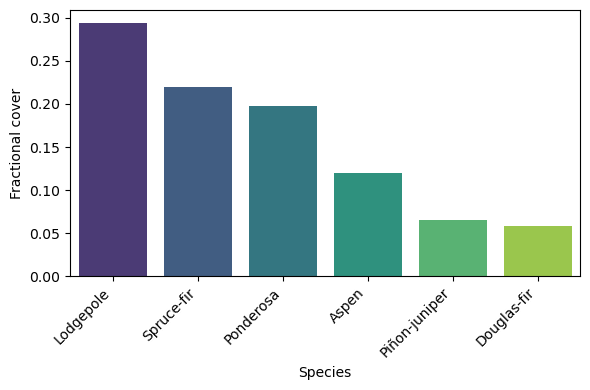

In [15]:
# cleanup the forest type names
species_rename = {
    'Pinon-juniper woodland': 'Piñon-juniper',
    'Douglas-fir': 'Douglas-fir',
    'Ponderosa pine': 'Ponderosa',
    'Lodgepole pine': 'Lodgepole',
    'Spruce-fir': 'Spruce-fir',
    'Aspen': 'Aspen'
}

# Rename species in the tiles dataframe
fortyp['SpeciesName'] = fortyp['SpeciesName'].replace(species_rename)

# re-plot the dataframe
# Calculate the total percent cover (prevalence)
spp_pr = fortyp.groupby('SpeciesName')['count'].sum().reset_index()
spp_pr['fraction'] = spp_pr['count'] / spp_pr['count'].sum()
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)

# which species make up 97% of observations?
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[spp_pr['c_fraction'] <= 0.97]
print(f"\n\nSpecies making up 97% of the total: \n\n{top_species}\n\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='SpeciesName', y='fraction', palette='viridis')
# plt.title('Burned area forest type fraction')
plt.xlabel('Species')
plt.ylabel('Fractional cover')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig(os.path.join(projdir, 'figures/FigureX_FORTYPCD_FractionalCover.png'), dpi=300, bbox_inches='tight')

plt.show()

In [16]:
# join the forest type dataframe to our FRP gridcells
grid_fortyp = grid.merge(fortyp, on='grid_index', how='left')
grid_fortyp.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_first',
       'day_max_frp', 'dt_max_frp', 'first_obs_date', 'last_obs_date',
       't4_max', 't4_mean', 't5_max', 't5_mean', 'day_count', 'night_count',
       'frp_max_day', 'frp_max_night', 'frp_csum_day', 'frp_csum_night',
       'frp_mean_day', 'frp_mean_night', 'frp_p90_day', 'frp_p90_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'grid_x', 'grid_y', 'SpeciesName', 'spp_pct', 'forest_pct', 'count',
       'total_pixels'],
      dtype='object')

In [17]:
# check for duplicates
print(f"Number of duplicate rows: {grid_fortyp.duplicated(subset=['grid_index', 'SpeciesName', 'spp_pct']).sum()}")
grid_fortyp = grid_fortyp.drop_duplicates(subset=['grid_index', 'SpeciesName', 'spp_pct'])

Number of duplicate rows: 0


In [18]:
# subset the grids to predominantly forested plots (>50% forested)
grid_forest = grid_fortyp[grid_fortyp['forest_pct'] > 50]
n_forest = len(grid_forest['grid_index'].unique())
print(f"{n_forest}/{len(grid)} [{round(n_forest/len(grid)*100,1)}%] gridcells are >50% forested.")

40498/46830 [86.5%] gridcells are >50% forested.


In [19]:
print(top_species['SpeciesName'].unique()) # check on our top species
# subset columns in our forested gridcells to retain just our top species
grid_forest = grid_forest[grid_forest['SpeciesName'].isin(top_species['SpeciesName'].unique())]
len(grid_forest['grid_index'].unique())

['Lodgepole' 'Spruce-fir' 'Ponderosa' 'Aspen' 'Piñon-juniper'
 'Douglas-fir']


40498

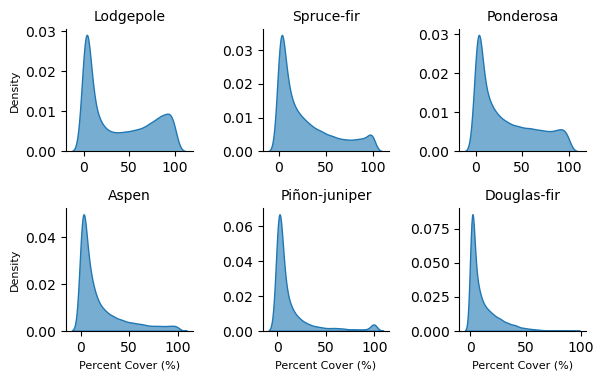

In [20]:
# plot the distribution of percent cover by forest types
grid_forest['SpeciesName'] = grid_forest['SpeciesName'].astype('category')

species_order = top_species['SpeciesName'].tolist()
grid_forest['SpeciesName'] = pd.Categorical(
    grid_forest['SpeciesName'],
    categories=species_order,
    ordered=True
)

# Create a FacetGrid with the specified order
g = sns.FacetGrid(
    data=grid_forest,
    col='SpeciesName',      
    col_wrap=3,             
    sharex=False,            
    sharey=False,            
    height=2,               
    aspect=1.2              
)

# Map a KDE plot to each facet
g.map(sns.kdeplot, 'spp_pct', fill=True, alpha=0.6)

# Customize the plot
g.set_titles("{col_name}")  # Use species names as titles
g.set_axis_labels("Percent Cover (%)", "Density", size=8)  # Axis labels
g.fig.set_size_inches(6,4)  # Set figure dimensions
plt.subplots_adjust(top=0.9)  # Adjust subplot spacing

# g.fig.tick_params(axis='both', which='major', labelsize=8)  # Change 10 to desired font size

# Show the plot
plt.show()

In [21]:
# save the TreeMap table out.
out_fp = os.path.join(projdir,'data/tabular/mod/viirs_snpp_jpss1_gridstats_fortypcd.csv')
grid_forest.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/viirs_snpp_jpss1_gridstats_fortypcd.csv


In [22]:
grid_forest.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_first',
       'day_max_frp', 'dt_max_frp', 'first_obs_date', 'last_obs_date',
       't4_max', 't4_mean', 't5_max', 't5_mean', 'day_count', 'night_count',
       'frp_max_day', 'frp_max_night', 'frp_csum_day', 'frp_csum_night',
       'frp_mean_day', 'frp_mean_night', 'frp_p90_day', 'frp_p90_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'grid_x', 'grid_y', 'SpeciesName', 'spp_pct', 'forest_pct', 'count',
       'total_pixels'],
      dtype='object')

In [23]:
# make some plots showing the distribution of FRP across forest types
# first, gather the dominant forest type
dfortyp = grid_forest.loc[grid_forest.groupby('grid_index')['spp_pct'].idxmax()]
print(dfortyp['SpeciesName'].unique())
print("\n")

# drop any 0 FRP gridcells
n_zero = len(dfortyp[dfortyp['frp_max'] == 0]) 
print(f"Dropping {n_zero} [{round(n_zero/len(dfortyp)*100,1)}%] gridcells w/ <1 cumulative FRP.")
dfortyp = dfortyp[(dfortyp['frp_max'] > 0)]

['Piñon-juniper', 'Ponderosa', 'Aspen', 'Douglas-fir', 'Lodgepole', 'Spruce-fir']
Categories (6, object): ['Lodgepole' < 'Spruce-fir' < 'Ponderosa' < 'Aspen' < 'Piñon-juniper' < 'Douglas-fir']


Dropping 0 [0.0%] gridcells w/ <1 cumulative FRP.


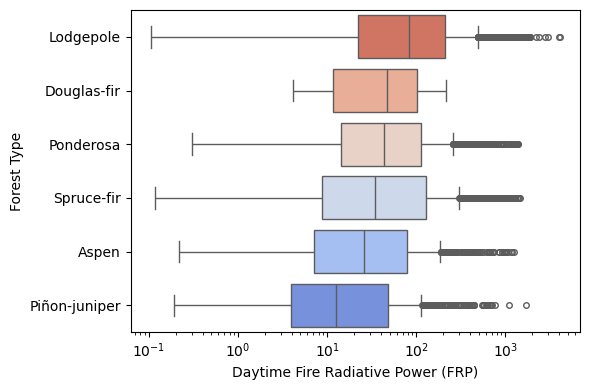


Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/FigureX_FORTYPCD_DominantSpecies_FRPmax.png



In [24]:
# Plot FRP by dominant forest type
# Find the median and sort the forest types by FRP
med = dfortyp.groupby('SpeciesName')['frp_max'].median().sort_values(ascending=False)
sorted = med.index.tolist()

# create a dataframe with dominance (>90% of the same species)
dom = dfortyp[dfortyp['spp_pct'] > 80]

# plot it
plt.figure(figsize=(6, 4)) 

sns.boxplot(
    data=dom, 
    x='frp_max', 
    y='SpeciesName', 
    order=sorted, 
    palette='coolwarm_r', 
    fliersize=4,
    dodge=False)

plt.xscale('log') # log-scale FRP
plt.xlabel('Daytime Fire Radiative Power (FRP)')
plt.ylabel('Forest Type')
plt.tight_layout()

out_plot = os.path.join(projdir, 'figures/FigureX_FORTYPCD_DominantSpecies_FRPmax.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()
print(f"\nSaved to: {out_plot}\n")

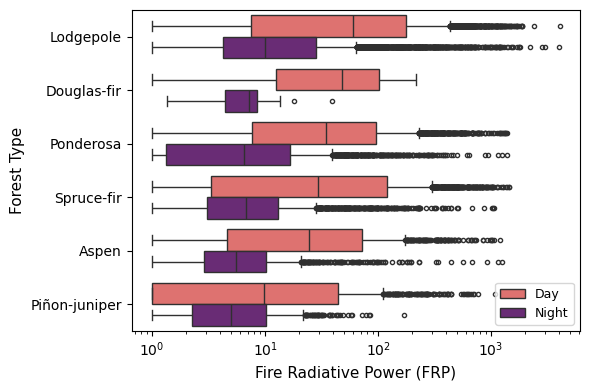


Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/FigureX_FORTYPCD_DominantSpecies_FRPmax_DayNight.png



In [25]:
dom_ = dom.copy()
dom_['frp_max_day'] = dom_['frp_max_day'] + 1
dom_['frp_max_night'] = dom_['frp_max_night'] + 1

# Find the median and sort the forest types by FRP
med = dom_.groupby('SpeciesName')['frp_max_day'].median().sort_values(ascending=False)
sorted = med.index.tolist()

# Reshape the data to long format for both day and night FRP
dom_l = pd.melt(
    dom_, 
    id_vars=['SpeciesName'], 
    value_vars=['frp_max_day', 'frp_max_night'], 
    var_name='DayNight', 
    value_name='FRP'
)

# Map `Time` values for clearer labels
dom_l['DayNight'] = dom_l['DayNight'].map({'frp_max_day': 'Day', 'frp_max_night': 'Night'})

# Create the plot
plt.figure(figsize=(6, 4))

sns.boxplot(
    data=dom_l,
    x="FRP",
    y="SpeciesName",
    hue="DayNight",
    order=sorted,
    palette='magma_r',
    fliersize=3,
)

plt.xscale('log')  # Log-scale FRP
plt.xlabel('Fire Radiative Power (FRP)', fontsize=11)
plt.ylabel('Forest Type', fontsize=11)
plt.legend(title='', loc='lower right', fontsize=9)
plt.tight_layout()

# Save and show the plot
out_plot = os.path.join(projdir, 'figures/FigureX_FORTYPCD_DominantSpecies_FRPmax_DayNight.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSaved to: {out_plot}\n")

In [26]:
print(f"Counts of grid cells dominated by one species:\n\n{dom['SpeciesName'].value_counts()}\n")

Counts of grid cells dominated by one species:

SpeciesName
Lodgepole        6042
Spruce-fir       3088
Ponderosa        2906
Aspen            1122
Piñon-juniper     784
Douglas-fir        18
Name: count, dtype: int64



In [27]:
# forest type composition effects on FRP

In [28]:
# get aspen grids (any aspen component)
# get gridcells with at least some aspen
aspen_idx = grid_forest[grid_forest['SpeciesName'] == 'Aspen']['grid_index'].unique() # list of grid indices
grid_aspen = grid_forest[grid_forest['grid_index'].isin(aspen_idx)]

# check how many aspen gridcells there are
n_aspen = len(grid_aspen['grid_index'].unique())
print(f"There are a total of {n_aspen} [{round(n_aspen/len(grid_forest['grid_index'].unique())*100,1)}%] gridcells with some aspen component.")

There are a total of 25465 [62.9%] gridcells with some aspen component.


In [29]:
print(f"Number of duplicate rows: {grid_aspen.duplicated(subset=['grid_index', 'SpeciesName']).sum()}")

Number of duplicate rows: 0


In [30]:
# drop any 0 FRP gridcells
n_small = len(grid_aspen[grid_aspen['frp_max'] < 1]) # very small FRP values (cumulative)
grid_aspen = grid_aspen[grid_aspen['frp_max'] > 1]
print(f"Dropped {n_small} [{round(n_small/len(grid_aspen)*100,1)}%] gridcells w/ <1 cumulative FRP.")
grid_aspen[['grid_index','SpeciesName','spp_pct','forest_pct','frp_csum','frp_max','frp_max_day','frp_max_night','afd_count']].head()

Dropped 1865 [1.6%] gridcells w/ <1 cumulative FRP.


,grid_index,SpeciesName,spp_pct,forest_pct,frp_csum,frp_max,frp_max_day,frp_max_night,afd_count
0,824824,Aspen,79.473684,96.446701,8.942974,8.942974,8.942974,0.0,1
1,824824,Douglas-fir,0.526316,96.446701,8.942974,8.942974,8.942974,0.0,1
3,824824,Piñon-juniper,0.526316,96.446701,8.942974,8.942974,8.942974,0.0,1
4,824824,Ponderosa,2.105263,96.446701,8.942974,8.942974,8.942974,0.0,1
5,824824,Spruce-fir,16.315789,96.446701,8.942974,8.942974,8.942974,0.0,1


Associate forest type: ['Douglas-fir', 'Piñon-juniper', 'Ponderosa', 'Spruce-fir', 'Lodgepole']



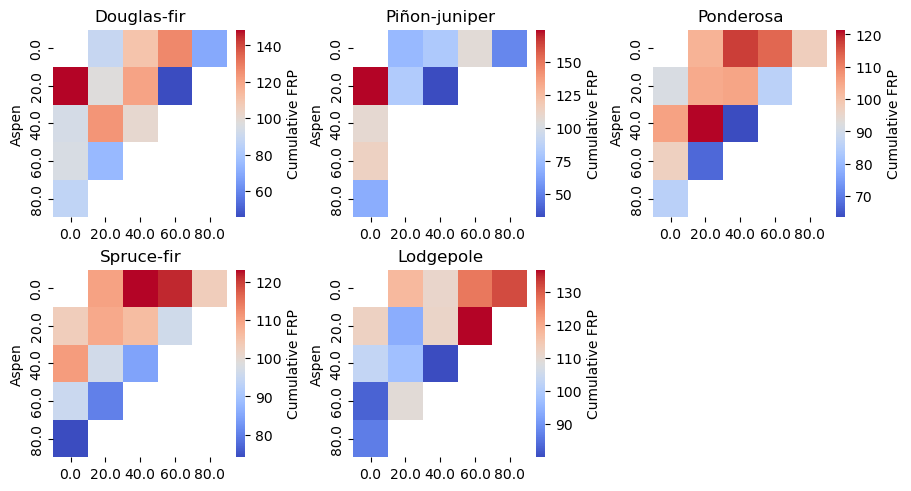

In [31]:
# create bins for species composition
bins = np.linspace(0, 100, 6) # 10% intervals
spps = [s for s in grid_aspen['SpeciesName'].unique() if s != 'Aspen'] # exclude aspen from species list
print(f"Associate forest type: {spps}\n")

df = grid_aspen.copy() # work with a copy

heatmap_das = [] # to store the plotting data
for sp in spps:
    df_sp = df[df['SpeciesName'].isin(['Aspen', sp])]

    # recalculate forest percent based on just these species
    # df_sp = df_sp.merge(forest, on='grid_index', how='left')
    # df_sp = df_sp[df_sp['forest_pct_c'] > 10]
    
    # Pivot table to create columns for Aspen and the species
    cover_df = (
        df_sp.pivot_table(index='grid_index', columns='SpeciesName', values='spp_pct', fill_value=0)
        .reset_index()
        .rename(columns={'Aspen': 'aspen_pct', sp: f'{sp}_pct'})
    )

    # make sure there is some of each kind
    cover_df['combined_pct'] = cover_df['aspen_pct'] + cover_df[f'{sp}_pct']
    cover_df = cover_df[cover_df['combined_pct'] > 50]
    
    # Merge with FRP data
    frp_df = grid_aspen[['grid_index', 'frp_max', 'frp_max_day', 'frp_max_night', 'frp_csum', 'frp_p90']].drop_duplicates()
    cover_df = cover_df.merge(frp_df, on='grid_index', how='left')

    # Bin the Aspen and species percent cover
    cover_df['aspen_bin'] = pd.cut(cover_df['aspen_pct'], bins, labels=bins[:-1])
    cover_df[f'{sp}_bin'] = pd.cut(cover_df[f'{sp}_pct'], bins, labels=bins[:-1])

    # Group by bins and calculate mean FRP
    heatmap_da = cover_df.groupby(['aspen_bin', f'{sp}_bin'])['frp_max_day'].mean().unstack()
    heatmap_da = heatmap_da.replace(0, np.nan)
    heatmap_das.append((sp, heatmap_da))

# create the plot
sp_size = 3
n_cols = 3  # Number of columns in the facet grid
n_rows = int(np.ceil(len(heatmap_das) / n_cols))

fig_w = sp_size * n_cols
fig_h = sp_size * 1.6

fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), constrained_layout=True)
axes = axes.flatten()

# get the global min/max
vmin = min(hm_da.min().min() for _, hm_da in heatmap_das)
vmax = max(hm_da.max().max() for _, hm_da in heatmap_das)

for i, (sp, hm_da) in enumerate(heatmap_das):
    ax = axes[i]
    sns.heatmap(
        hm_da, cmap='coolwarm', annot=False, fmt=".1f", 
        cbar_kws={'label': 'Cumulative FRP'}, ax=ax,
        square=False
    )
    ax.set_title(f'{sp}')
    ax.set_xlabel('')
    ax.set_ylabel('Aspen')

# Remove unused subplots if species < n_rows * n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

del df

out_plot = os.path.join(projdir, 'figures/FigureX_CoOccurring_Heatmap_FRPmax_Day.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()

Associate forest type: ['Douglas-fir', 'Piñon-juniper', 'Ponderosa', 'Spruce-fir', 'Lodgepole']



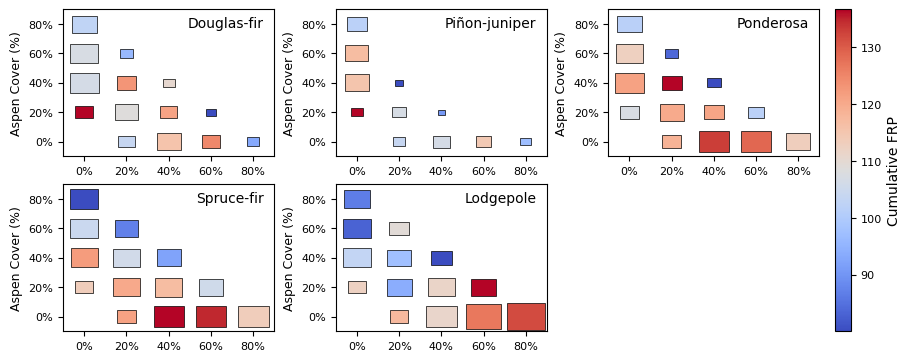

In [32]:
# waffle chart version

# create bins for species composition
bins = np.linspace(0, 100, 6) # 20% intervals
spps = [s for s in grid_aspen['SpeciesName'].unique() if s != 'Aspen'] # exclude aspen from species list
print(f"Associate forest type: {spps}\n")

df = grid_aspen.copy()

# create grid data
tiles = []  # Store tile data
for sp in spps:
    # Filter for co-occurrence
    df_sp = df[df['SpeciesName'].isin(['Aspen', sp])]

    # Pivot to create columns for Aspen and the species
    cover_df = (
        df_sp.pivot_table(index='grid_index', columns='SpeciesName', values='spp_pct', fill_value=0)
        .reset_index()
        .rename(columns={'Aspen': 'aspen_pct', sp: f'{sp}_pct'})
    )

    # make sure there is some of each kind
    cover_df['combined_pct'] = cover_df['aspen_pct'] + cover_df[f'{sp}_pct']
    cover_df = cover_df[cover_df['combined_pct'] > 50]

    # Merge with FRP data
    frp_df = grid_aspen[['grid_index', 'frp_max', 'frp_max_day', 'frp_max_night', 'frp_csum', 'frp_p90']].drop_duplicates()
    cover_df = cover_df.merge(frp_df, on='grid_index', how='left')

    # Bin Aspen and species percent cover
    cover_df['aspen_bin'] = pd.cut(cover_df['aspen_pct'], bins, labels=range(len(bins) - 1))
    cover_df[f'{sp}_bin'] = pd.cut(cover_df[f'{sp}_pct'], bins, labels=range(len(bins) - 1))

    # Group by bins and calculate statistics
    grouped = cover_df.groupby(['aspen_bin', f'{sp}_bin'])
    counts = grouped.size().reset_index(name='freq')  # Frequency for tile size
    mean_frp = grouped['frp_max_day'].mean().reset_index(name='frp')  # Mean FRP for color

    # Merge statistics into a single DataFrame
    tiled_data = pd.merge(counts, mean_frp, on=['aspen_bin', f'{sp}_bin'])
    tiled_data['species'] = sp
    tiles.append(tiled_data)

# Combine tile data
tiles_df = pd.concat(tiles, ignore_index=True)
tiles_df['log_frp'] = np.log10(tiles_df['frp'] + 1)

# Normalize tile sizes (scale frequency)
tiles_df['tile_size'] = (tiles_df['freq'] / tiles_df['freq'].max()) ** 0.2  # Square root scaling for better size balance

# Plotting the tile-scaled heatmap
n_cols = 3  # Number of columns in the facet grid
n_rows = int(np.ceil(len(spps) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(9,3.5), constrained_layout=True)
axes = axes.flatten()

vmin = tiles_df['log_frp'].min()
vmax = tiles_df['log_frp'].quantile()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Define color normalization based on raw FRP range

log_frp_min = np.percentile(tiles_df['log_frp'], 10)
log_frp_max = np.percentile(tiles_df['log_frp'], 90)

# make the grids
for i, sp in enumerate(spps):
    sp_data = tiles_df[tiles_df['species'] == sp]
    ax = axes[i]

    vmin = sp_data['frp'].min()
    vmax = sp_data['frp'].max()

    for _, row in sp_data.iterrows():
        x = int(row[f'{sp}_bin'])  
        y = int(row['aspen_bin'])  
        size = row['tile_size'] * 0.9
        
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        color = plt.cm.coolwarm(norm(row['frp']))
        
        ax.add_patch(
            plt.Rectangle(
                (x - size / 2, y - size / 2), size, size, color=color, ec='black', lw=0.5
            )
        )

    # Formatting the axes
    # ax.set_title(sp, size=10)
    ax.text(
        0.95, 0.95, sp,  # x, y position in axis coordinates (top-right corner)
        transform=ax.transAxes,  # Use axis coordinates (0,0 is bottom-left, 1,1 is top-right)
        ha='right', va='top',  # Align the text to the top-right
        fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2')
    )
    ax.set_xlabel(f'')
    ax.set_ylabel('Aspen Cover (%)', size=9)
    ax.set_xticks(range(len(bins) - 1))
    ax.set_yticks(range(len(bins) - 1))
    ax.set_xticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
    ax.set_yticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
    ax.set_xlim(-0.5, len(bins) - 1.5)
    ax.set_ylim(-0.5, len(bins) - 1.5)

    # sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
    # cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.50, pad=0.1)
    # cbar.set_label('Maximum FRP')

sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.05, pad=0.02)
cbar.set_label('Maximum FRP')
cbar.set_label('Cumulative FRP', fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

del df

out_plot = os.path.join(projdir, 'figures/FigureX_CoOccurring_Heatmap_FRPmax_Scaled.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()

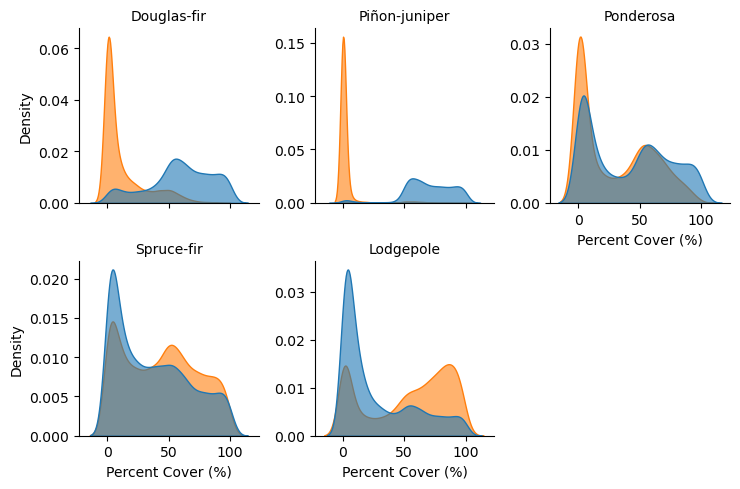

In [33]:
# plot the distribution of percent cover
df = grid_aspen.copy() # work with a copy

kde_data = []
for sp in spps:
    df_sp = df[df['SpeciesName'].isin(['Aspen', sp])]

    # Pivot table to create columns for Aspen and the species
    cover_df = (
        df_sp.pivot_table(index='grid_index', columns='SpeciesName', values='spp_pct', fill_value=0)
        .reset_index()
        .rename(columns={'Aspen': 'Aspen', sp: sp})
    )

    # Filter for co-occurrence
    cover_df['combined_pct'] = cover_df['Aspen'] + cover_df[sp]
    cover_df = cover_df[cover_df['combined_pct'] > 50]

    # Melt data for Seaborn FacetGrid
    melted = cover_df.melt(
        id_vars='grid_index', 
        value_vars=['Aspen', sp], 
        var_name='species', 
        value_name='pct_cover'
    )
    melted['other_spp'] = sp  # Add metadata for faceting
    kde_data.append(melted)

# Combine data for all species
kde_data_df = pd.concat(kde_data, ignore_index=True)

# FacetGrid with the fixed palette
g = sns.FacetGrid(kde_data_df, col="other_spp", col_wrap=3, height=2.5, sharex=True, sharey=False)

# Map kdeplot with consistent colors
g.map_dataframe(
    sns.kdeplot, 
    x="pct_cover", 
    hue="species", 
    fill=True, 
    alpha=0.6, 
    common_norm=False, 
)

# Adjust labels and titles
g.set_titles("{col_name}")
g.set_axis_labels("Percent Cover (%)", "Density")
g.tight_layout()

out_plot = os.path.join(projdir, 'figures/FigureX_CoOccurring_CoverDistribution.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()

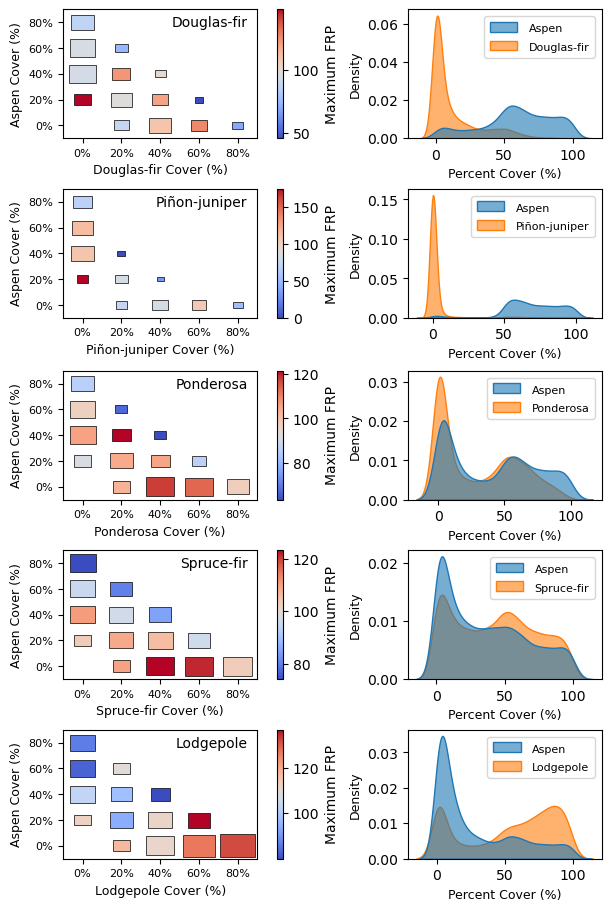

In [34]:
# Number of rows based on species
n_rows = len(spps)  # One row per species
fig, axes = plt.subplots(n_rows, 2, figsize=(6, 9), constrained_layout=True)

for i, sp in enumerate(spps):
    # ===== TILE PLOT =====
    sp_data = tiles_df[tiles_df['species'] == sp]
    ax_tile = axes[i, 0]

    # Tile Plot Data
    sp_vmin = sp_data['frp'].min()
    sp_vmax = sp_data['frp'].max()
    norm = mcolors.Normalize(vmin=sp_vmin, vmax=sp_vmax)

    for _, row in sp_data.iterrows():
        x = int(row[f'{sp}_bin'])
        y = int(row['aspen_bin'])
        size = row['tile_size'] * 0.9
        color = plt.cm.coolwarm(norm(row['frp']))

        ax_tile.add_patch(
            plt.Rectangle(
                (x - size / 2, y - size / 2), size, size, color=color, ec='black', lw=0.5
            )
        )

    # Formatting Tile Plot
    ax_tile.text(
        0.95, 0.95, sp,  # Top-right corner
        transform=ax_tile.transAxes,
        ha='right', va='top',
        fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2')
    )
    ax_tile.set_xlabel(f'{sp} Cover (%)', size=9)
    ax_tile.set_ylabel('Aspen Cover (%)', size=9)
    ax_tile.set_xticks(range(len(bins) - 1))
    ax_tile.set_yticks(range(len(bins) - 1))
    ax_tile.set_xticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
    ax_tile.set_yticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
    ax_tile.set_xlim(-0.5, len(bins) - 1.5)
    ax_tile.set_ylim(-0.5, len(bins) - 1.5)

    # Add colorbar to tile plot
    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
    cbar = fig.colorbar(sm, ax=ax_tile, orientation='vertical', fraction=0.05, pad=0.1)
    cbar.set_label('Maximum FRP')

    # ===== KDE PLOT =====
    sp_kde_data = kde_data_df[kde_data_df["other_spp"] == sp]
    ax_kde = axes[i, 1]

    # cp = {
    #     "Aspen": "#7fbf7b",  
    #     sp: "#af8dc3"         
    # }
   
    sns.kdeplot(data=sp_kde_data, 
        x="pct_cover", 
        hue="species", 
        fill=True, 
        alpha=0.6, 
        common_norm=False,
        # palette=cp,
        ax=ax_kde,
    )

    # Formatting KDE Plot
    # ax_kde.set_title(f'{sp}', size=10)
    ax_kde.set_xlabel('Percent Cover (%)', size=9)
    ax_kde.set_ylabel('Density', size=9)

    legend = ax_kde.legend_  # Get the legend object for the KDE plot
    if legend:
        legend.set_title("")  # Remove the legend title
        for text in legend.get_texts():  # Adjust the size of legend text
            text.set_fontsize(8)
            
# Adjust layout and show plot
# plt.tight_layout()

out_plot = os.path.join(projdir, 'figures/FigureX_CoOccurring_Heatmap_CoverDistribution.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()

In [35]:
# plot the heatmap for just conifer/aspen

In [36]:
grid_forest['SpeciesName'].unique()

['Aspen', 'Douglas-fir', 'Piñon-juniper', 'Ponderosa', 'Spruce-fir', 'Lodgepole']
Categories (6, object): ['Lodgepole' < 'Spruce-fir' < 'Ponderosa' < 'Aspen' < 'Piñon-juniper' < 'Douglas-fir']

 Forest classes: ['Aspen' 'Conifer']



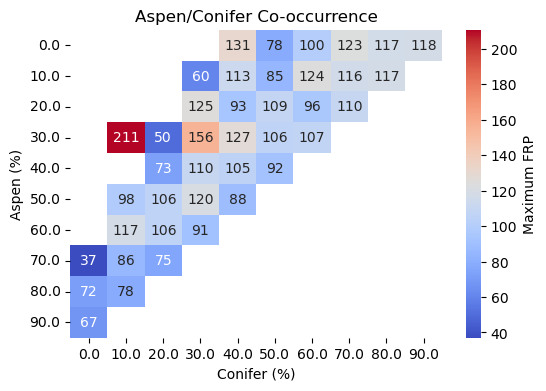

In [37]:
# conifer/aspen
df = grid_forest.copy() # work with a copy

# label conifer/aspen, summarize percent cover
df['ForestPhys'] = df['SpeciesName'].apply(lambda x: 'Conifer' if x != 'Aspen' else x)
print(f" Forest classes: {df['ForestPhys'].unique()}\n")

# Recalculate percent cover
cover_df = (
    df.groupby(['grid_index', 'ForestPhys'])['spp_pct']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={'Aspen': 'aspen_pct', 'Conifer': 'conifer_pct'})
)

cover_df['combined_pct'] = cover_df['aspen_pct'] + cover_df['conifer_pct']
cover_df = cover_df[cover_df['combined_pct'] > 50]

# # make sure there is some aspen 
# cover_df = cover_df[(cover_df['aspen_pct'] > 0) & (cover_df['conifer_pct'] > 0)] # make sure is some aspen

# merge back to FRP
cover_df = cover_df.merge(grid[['grid_index', 'frp_max', 'frp_max_day', 
                                'frp_max_night', 'frp_csum', 'frp_p90']], 
                          on='grid_index', how='left')

# # filter based on the 'forest_pct'
# cover_df = cover_df[cover_df['forest_pct'] > 50]
# print(f">50 % combined forested plots: {len(cover_df_)} of {len(cover_df)}\n")

# bin the data and plot the heatmap
bins = np.linspace(0, 100, 11)  # 10% intervals
cover_df['aspen_bin'] = pd.cut(cover_df['aspen_pct'], bins, labels=bins[:-1])
cover_df['conifer_bin'] = pd.cut(cover_df['conifer_pct'], bins, labels=bins[:-1])

# create the summarized data by bins (heatmap)
heatmap_da = cover_df.groupby(['aspen_bin', 'conifer_bin']).frp_max_day.mean().unstack()
heatmap_da = heatmap_da.replace(0, np.nan)

# heatmap_da_log = np.log10(heatmap_da + 1e-6)

# plot it
plt.figure(figsize=(6, 4))

sns.heatmap(
    heatmap_da, 
    cmap='coolwarm', 
    annot=True, 
    fmt=".0f", 
    cbar_kws={'label': 'Maximum FRP'}
)

plt.title("Aspen/Conifer Co-occurrence", size=12, loc='center')
plt.xlabel('Conifer (%)')
plt.ylabel('Aspen (%)')

out_plot = os.path.join(projdir, 'figures/FigureX_ConiferAspen_Heatmap_FRPmax.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()

In [38]:
# scaled tile version
# conifer/aspen
df = grid_forest.copy() # work with a copy

# label conifer/aspen, summarize percent cover
df['ForestPhys'] = df['SpeciesName'].apply(lambda x: 'Conifer' if x != 'Aspen' else x)
print(f" Forest classes: {df['ForestPhys'].unique()}\n")

# Recalculate percent cover
cover_df = (
    df.groupby(['grid_index', 'ForestPhys'])['spp_pct']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={'Aspen': 'aspen_pct', 'Conifer': 'conifer_pct'})
)

cover_df['combined_pct'] = cover_df['aspen_pct'] + cover_df['conifer_pct']
# cover_df = cover_df[cover_df['combined_pct'] > 60]

# Merge with FRP data
frp_df = grid_aspen[['grid_index', 'frp_max', 'frp_max_day', 
                     'frp_max_night', 'frp_csum', 'frp_p90']].drop_duplicates()
cover_df = cover_df.merge(frp_df, on='grid_index', how='left')

# Bin Aspen and species percent cover
bins = np.linspace(0, 100, 11)  # 10% intervals
cover_df['aspen_bin'] = pd.cut(cover_df['aspen_pct'], bins, labels=bins[:-1])
cover_df['conifer_bin'] = pd.cut(cover_df['conifer_pct'], bins, labels=bins[:-1])

# Group by bins and calculate statistics
grouped = cover_df.groupby(['aspen_bin', 'conifer_bin'])
counts = grouped.size().reset_index(name='freq')  # Frequency for tile size
mean_frp = grouped['frp_max_day'].mean().reset_index(name='frp')  # Mean FRP for color

# Merge statistics into a single DataFrame
tiles_df = pd.merge(counts, mean_frp, on=['aspen_bin', 'conifer_bin'])
tiles_df['tile_size'] = (tiles_df['freq'] / tiles_df['freq'].max()) ** 0.2

# create the plot
tiles_df['aspen_bin_idx'] = tiles_df['aspen_bin'].cat.codes
tiles_df['conifer_bin_idx'] = tiles_df['conifer_bin'].cat.codes

# get the KDE plot for aspen/conifer
kde_data = cover_df.melt(
    id_vars='grid_index', 
    value_vars=['aspen_pct', 'conifer_pct'], 
    var_name='species', 
    value_name='pct_cover'
)

# Rename for consistent labeling
kde_data['species'] = kde_data['species'].replace({
    'aspen_pct': 'Aspen', 
    'conifer_pct': 'Conifer'
})

 Forest classes: ['Aspen' 'Conifer']



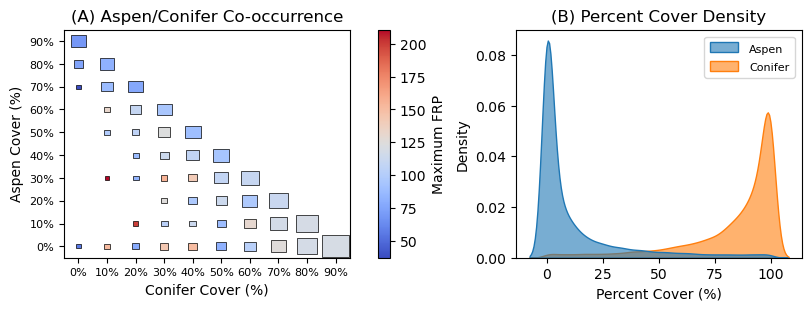


Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/FigureX_ConiferAspen_Combined.png



In [39]:
# Create a single figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)  # Adjust layout for better spacing

# First Plot: Tile plot (Aspen/Conifer Co-occurrence)
ax1 = axes[0]

# Normalize the color scale
vmin = tiles_df['frp'].min()
vmax = tiles_df['frp'].max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

for _, row in tiles_df.iterrows():
    x = row['conifer_bin_idx']  # Conifer bin index
    y = row['aspen_bin_idx']    # Aspen bin index
    size = row['tile_size'] * 0.95  # Adjust tile size

    # Determine the color based on FRP
    color = plt.cm.coolwarm(norm(row['frp']))

    # Add a rectangle to the plot
    ax1.add_patch(
        plt.Rectangle(
            (x - size / 2, y - size / 2), size, size, color=color, ec='black', lw=0.5
        )
    )

# Formatting the tile plot
ax1.set_title("(A) Aspen/Conifer Co-occurrence", size=12, loc='center')
ax1.set_xlabel('Conifer Cover (%)', size=10)
ax1.set_ylabel('Aspen Cover (%)', size=10)
ax1.set_xticks(range(len(bins) - 1))
ax1.set_yticks(range(len(bins) - 1))
ax1.set_xticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
ax1.set_yticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
ax1.set_xlim(-0.5, len(bins) - 1.5)
ax1.set_ylim(-0.5, len(bins) - 1.5)

# Add colorbar to the tile plot
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
cbar = fig.colorbar(sm, ax=ax1, orientation='vertical', fraction=0.05, pad=0.1)
cbar.set_label('Maximum FRP', size=10)

# Second Plot: KDE plot
ax2 = axes[1]

sns.kdeplot(data=kde_data, 
    x="pct_cover", 
    hue="species", 
    fill=True, 
    alpha=0.6, 
    common_norm=False,
    ax=ax2,
)

# Formatting the KDE plot
ax2.set_title("(B) Percent Cover Density", size=12)
ax2.set_xlabel('Percent Cover (%)', size=10)
ax2.set_ylabel('Density', size=10)

legend = ax2.legend_  # Get the legend object for the KDE plot
if legend:
    legend.set_title("")  # Remove the legend title
    for text in legend.get_texts():  # Adjust the size of legend text
        text.set_fontsize(8)

# Save the combined plot
out_plot_combined = os.path.join(projdir, 'figures/FigureX_ConiferAspen_Combined.png')
plt.savefig(out_plot_combined, dpi=300, bbox_inches='tight')

# Show the combined plot
plt.show()

print(f"\nSaved to: {out_plot_combined}\n")

In [40]:
# Load the treemap metrics, apply the same remapping

In [41]:
ftyp_met = os.path.join(projdir,'data/earth-engine/exports/treemap/gridstats_fortypcd_metrics.csv')
tm_stats = pd.read_csv(ftyp_met)
tm_stats.drop(columns=['system:index','.geo'], inplace=True)
tm_stats.columns

Index(['grid_index', 'species_metrics'], dtype='object')

In [42]:
# unpack histogram dictionary into columns
def parse_histogram(hist_str):
    # Convert float or NaN to string, then parse
    if isinstance(hist_str, float) or pd.isna(hist_str):
        hist_str = str(int(hist_str)) if not pd.isna(hist_str) else ""
    kv_pairs = hist_str.split(', ')  # Split the key-value pairs
    # Convert key-value pairs to a dictionary
    return {kv.split(':')[0]: float(kv.split(':')[1]) for kv in kv_pairs if ':' in kv}

# parse the dictionary
tm_stats['species_metrics'] = tm_stats['species_metrics'].apply(parse_histogram)
hist_df = tm_stats['species_metrics'].apply(pd.Series)
tm_stats = pd.concat([tm_stats.drop(columns=['species_metrics']), hist_df], axis=1).reset_index(drop=True)
print("Adjusted DataFrame:")
tm_stats.head(3)

Adjusted DataFrame:


,grid_index,182_BALIVE_mn,182_SDIPCT_RMRS_mn,182_STANDHT_mn,182_TPA_DEAD_mn,182_TPA_LIVE_mn,185_BALIVE_mn,185_SDIPCT_RMRS_mn,185_STANDHT_mn,185_TPA_DEAD_mn,...,976_BALIVE_mn,976_STANDHT_mn,976_TPA_DEAD_mn,976_TPA_LIVE_mn,507_BALIVE_mn,507_STANDHT_mn,507_TPA_LIVE_mn,924_BALIVE_mn,924_STANDHT_mn,924_TPA_LIVE_mn
0,919906,113.513901,65.199997,29.0,12.036092,396.670441,44.991299,26.083333,20.285714,9.027069,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,919907,113.513901,65.199997,29.0,12.036092,396.670441,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,919908,63.252056,33.140844,29.0,12.036092,146.540987,52.111698,25.000000,30.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# isolate melt bands/columns
band_names = ['BALIVE', 'SDIPCT_RMRS', 'STANDHT', 'TPA_DEAD', 'TPA_LIVE']
regex_p = '|'.join(band_names) # regex pattern for melting columns
metrics_cols = [col for col in tm_stats.columns if '_mn' in col]
print(f"[{len(metrics_cols)}] total metrics columns selected for melting:\n")

# do the melt
tm_stats_l = tm_stats.melt(
    id_vars=['grid_index'], 
    value_vars=metrics_cols, 
    var_name='metric', 
    value_name='value'
)
tm_stats_l.head(3)

[257] total metrics columns selected for melting:



,grid_index,metric,value
0,919906,182_BALIVE_mn,113.513901
1,919907,182_BALIVE_mn,113.513901
2,919908,182_BALIVE_mn,63.252056


In [44]:
# gather the forest type code from the band name
tm_stats_l['FORTYPCD'] = (
    tm_stats_l['metric']
    .str.extract(r'^(\d+)_')[0]
    .dropna()  # Remove rows with NaN
    .astype(int)
)
tm_stats_l['metric'] = tm_stats_l['metric'].str.extract(f'({regex_p})')[0]
tm_stats_l = tm_stats_l[['grid_index','FORTYPCD','metric','value']]
tm_stats_l.dropna(subset=['value'], inplace=True) # drop NaNs
tm_stats_l['metric'].unique()

array(['BALIVE', 'SDIPCT_RMRS', 'STANDHT', 'TPA_DEAD', 'TPA_LIVE'],
      dtype=object)

In [45]:
# pivot longer to get metrics as columns
tm_stats_lp = tm_stats_l.pivot_table(index=['grid_index', 'FORTYPCD'], columns='metric', values='value')
tm_stats_lp = tm_stats_lp.reset_index() # collapse the index
tm_stats_lp = tm_stats_lp[['grid_index','FORTYPCD']+band_names]
tm_stats_lp.rename(columns={'SDIPCT_RMRS': 'SDIPCT'}, inplace=True)
tm_stats_lp.head(3)

metric,grid_index,FORTYPCD,BALIVE,SDIPCT,STANDHT,TPA_DEAD,TPA_LIVE
0,184440,184,28.642924,12.543885,12.183448,6.018046,36.084544
1,184440,185,46.993341,18.682264,15.118729,12.178753,141.248148
2,184441,184,72.685503,32.056522,14.415356,9.027069,78.017484


In [46]:
# load the species lookup table
fp = os.path.join(projdir,'data/tabular/mod/treemap_fortypcd_species_mapping.csv')
species_df = pd.read_csv(fp)
species_df = species_df[['FORTYPCD','SpeciesName']]
species_df = species_df[species_df['FORTYPCD'].isin(tm_stats_lp['FORTYPCD'].unique())]
print(species_df.columns)

# merge with grid summary to get forest species name
tm_stats_lp = tm_stats_lp.merge(species_df, on='FORTYPCD', how='left')
tm_stats_lp['SpeciesName'].unique()

Index(['FORTYPCD', 'SpeciesName'], dtype='object')


array(['Juniper woodland', 'Pinyon / juniper woodland', 'Cottonwood',
       'Mesquite woodland', 'Other exotic hardwoods',
       'Deciduous oak woodland', 'Rocky Mountain juniper',
       'Ponderosa pine', 'Western juniper',
       'Sugarberry / hackberry / elm / green ash', 'Other hardwoods',
       'Nonstocked', 'Douglas-fir', 'Cottonwood / willow', 'Bur oak',
       'Western redcedar', 'Grand fir', 'Aspen', 'White fir',
       'Cercocarpus (mountain brush) woodland', 'Lodgepole pine',
       'Engelmann spruce', 'Western larch',
       'Intermountain maple woodland', 'Engelmann spruce / subalpine fir',
       'Subalpine fir', 'Blue spruce', 'Limber pine', 'Balsam fir',
       'Foxtail pine / bristlecone pine', 'Paper birch',
       'Miscellaneous western softwoods', 'Noble fir',
       'Sugar maple / beech / yellow birch', 'Hard maple / basswood',
       'California mixed conifer', 'Jeffrey pine',
       'Evergreen oak woodland', 'Eastern redcedar / hardwood',
       'Elm / ash / b

In [47]:
# perform a remap for some forest types
# create a 'Spruce-fir' category
# 'Pinon-juniper woodland' category
spp_remap = {
    'Engelmann spruce': 'Spruce-fir',
    'Subalpine fir': 'Spruce-fir',
    'White fir': 'Spruce-fir',
    'Grand fir': 'Spruce-fir',
    'Engelmann spruce / subalpine fir': 'Spruce-fir',
    'Western juniper': 'Pinon-juniper woodland',
    'Rocky Mountain juniper': 'Pinon-juniper woodland',
    'Pinyon / juniper woodland': 'Pinon-juniper woodland',
    'Juniper woodland': 'Pinon-juniper woodland'
}

# Add a new column for the merged categories
tm_stats_lp['SpeciesName'] = tm_stats_lp['SpeciesName'].map(spp_remap).fillna(tm_stats_lp['SpeciesName'])

# Now handle the new columns (groupby and summarise)
tm_stats_lp_ = tm_stats_lp.groupby(['grid_index', 'SpeciesName'], as_index=False).agg({
    'BALIVE': 'mean',
    'SDIPCT': 'mean',
    'STANDHT': 'mean',
    'TPA_DEAD': 'sum',
    'TPA_LIVE': 'sum'
})

tm_stats_lp_.head(3)

,grid_index,SpeciesName,BALIVE,SDIPCT,STANDHT,TPA_DEAD,TPA_LIVE
0,184440,Pinon-juniper woodland,37.818133,15.613074,13.651088,18.196799,177.332691
1,184441,Pinon-juniper woodland,57.612499,22.614363,14.464458,29.485109,114.218375
2,184442,Pinon-juniper woodland,45.984108,16.302381,15.584066,35.247180,74.242753


In [48]:
# cleanup the forest type names
species_rename = {
    'Pinon-juniper woodland': 'Piñon-juniper',
    'Douglas-fir': 'Douglas-fir',
    'Ponderosa pine': 'Ponderosa',
    'Lodgepole pine': 'Lodgepole',
    'Spruce-fir': 'Spruce-fir',
    'Aspen': 'Aspen'
}

# Rename species in the tiles dataframe
tm_stats_lp_['SpeciesName'] = fortyp['SpeciesName'].replace(species_rename)
tm_stats_lp_.head(3)

,grid_index,SpeciesName,BALIVE,SDIPCT,STANDHT,TPA_DEAD,TPA_LIVE
0,184440,Piñon-juniper,37.818133,15.613074,13.651088,18.196799,177.332691
1,184441,Piñon-juniper,57.612499,22.614363,14.464458,29.485109,114.218375
2,184442,Piñon-juniper,45.984108,16.302381,15.584066,35.247180,74.242753


In [49]:
grid_forest.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_first',
       'day_max_frp', 'dt_max_frp', 'first_obs_date', 'last_obs_date',
       't4_max', 't4_mean', 't5_max', 't5_mean', 'day_count', 'night_count',
       'frp_max_day', 'frp_max_night', 'frp_csum_day', 'frp_csum_night',
       'frp_mean_day', 'frp_mean_night', 'frp_p90_day', 'frp_p90_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'grid_x', 'grid_y', 'SpeciesName', 'spp_pct', 'forest_pct', 'count',
       'total_pixels'],
      dtype='object')

In [50]:
# merge to grid_forest
grid_tmstats = grid_forest.merge(tm_stats_lp_, on=['grid_index','SpeciesName'], how='inner')
grid_tmstats.head()

,grid_index,grid_area,afd_count,unique_days,overlap,frp_csum,frp_max,frp_min,frp_mean,frp_p90,...,SpeciesName,spp_pct,forest_pct,count,total_pixels,BALIVE,SDIPCT,STANDHT,TPA_DEAD,TPA_LIVE
0,824824,140625.0,1,1,0.382136,8.942974,8.942974,8.942974,8.942974,8.942974,...,Douglas-fir,0.526316,96.446701,1.0,197.0,60.181301,19.200001,53.000000,0.000000,459.079041
1,824824,140625.0,1,1,0.382136,8.942974,8.942974,8.942974,8.942974,8.942974,...,Ponderosa,2.105263,96.446701,4.0,197.0,44.575798,NaN,71.029496,7.017234,126.767479
2,824824,140625.0,1,1,0.382136,8.942974,8.942974,8.942974,8.942974,8.942974,...,Spruce-fir,16.315789,96.446701,31.0,197.0,135.786055,32.818427,62.972047,265.335893,2242.966853
3,824825,140625.0,1,1,0.292200,6.838240,6.838240,6.838240,6.838240,6.838240,...,Aspen,72.538860,97.969543,140.0,197.0,104.276235,33.449260,54.402619,68.586723,372.790413
4,824827,140625.0,1,1,0.244679,2.845685,2.845685,2.845685,2.845685,2.845685,...,Aspen,42.929293,100.507614,85.0,197.0,133.820682,37.824129,65.964598,174.454852,1663.862993


In [51]:
# Identify the dominant forest type for each gridcell
tmstats_dtree = grid_tmstats.loc[grid_tmstats.groupby('grid_index')['spp_pct'].idxmax()]
print(tmstats_dtree['SpeciesName'].unique())

['Piñon-juniper' 'Ponderosa' 'Douglas-fir' 'Aspen' 'Lodgepole'
 'Spruce-fir']


In [52]:
# plot the distribution of FRP max and cumulative
print(f"Maximum FRP distribution:\n {tmstats_dtree['frp_max'].describe()}\n")
print(f"Cumulative FRP distribution:\n {tmstats_dtree['frp_csum'].describe()}\n")

Maximum FRP distribution:
 count    34194.000000
mean       128.927390
std        206.189617
min          0.110273
25%         14.529527
50%         53.149904
75%        156.313944
max       4224.420433
Name: frp_max, dtype: float64

Cumulative FRP distribution:
 count    34194.000000
mean       263.224370
std        346.422124
min          0.117123
25%         32.556778
50%        128.926266
75%        358.889649
max       4548.993138
Name: frp_csum, dtype: float64



In [53]:
# drop any 0 FRP gridcells
n_small = len(tmstats_dtree[tmstats_dtree['frp_csum'] < 1]) # very small FRP values (cumulative)
print(f"Dropping {n_small} [{round(n_small/len(tmstats_dtree)*100,1)}%] gridcells w/ <1 cumulative FRP.")
tmstats_dtree = tmstats_dtree[tmstats_dtree['frp_csum'] > 1]

Dropping 421 [1.2%] gridcells w/ <1 cumulative FRP.


In [54]:
# calculate the mean quadratic diameter (QMD)
tmstats_dtree = tmstats_dtree.dropna(subset=['BALIVE', 'TPA_LIVE'])  # Drop rows with missing values
tmstats_dtree = tmstats_dtree[tmstats_dtree['TPA_LIVE'] > 0]
tmstats_dtree['TPA_LD'] = tmstats_dtree['TPA_LIVE'] + tmstats_dtree['TPA_DEAD']
tmstats_dtree['QMD'] = np.sqrt((tmstats_dtree['BALIVE'] * 144) / (np.pi * tmstats_dtree['TPA_LD']))
print(tmstats_dtree[['BALIVE', 'TPA_LD', 'QMD']].head())

          BALIVE      TPA_LD       QMD
13197  57.612499  143.703484  4.286778
13198  36.797316  172.933410  3.123021
13199  41.706946   54.162415  5.941027
13200  45.102459  146.865387  3.751861
13201  40.000622   54.070422  5.823174


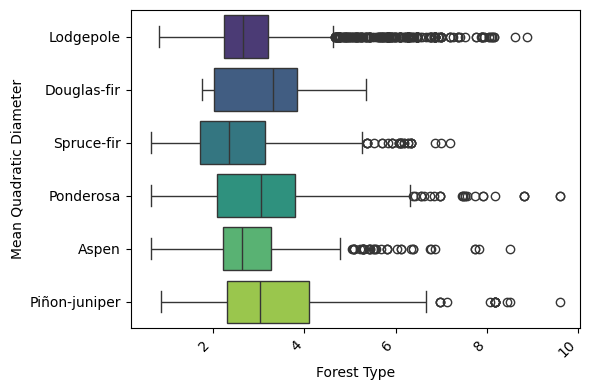


Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/FigureX_FORTYPCD_DominantSpecies_QMD.png



In [55]:
# plot QMD across species

# Find the median and sort the forest types by FRP
med = tmstats_dtree.groupby('SpeciesName')['frp_max'].median().sort_values(ascending=False)
sorted = med.index.tolist()

# create a dataframe with dominance (>90% of the same species)
dom = tmstats_dtree[tmstats_dtree['spp_pct'] > 80]

# plot it
plt.figure(figsize=(6, 4)) 

sns.boxplot(
    data=dom, 
    x='QMD', 
    y='SpeciesName', 
    order=sorted, 
    palette='viridis', 
    dodge=False)

# plt.xscale('log') # log-scale FRP
plt.xlabel('Forest Type')
plt.ylabel('Mean Quadratic Diameter')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

out_plot = os.path.join(projdir, 'figures/FigureX_FORTYPCD_DominantSpecies_QMD.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()
print(f"\nSaved to: {out_plot}\n")

<Figure size 600x400 with 0 Axes>

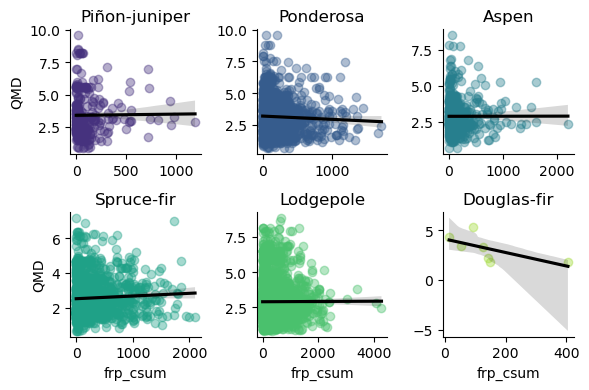

In [56]:
# scatter plot of BALIVE against max FRP for each species
# Apply log-transform to FRP for better visualization

df = tmstats_dtree.copy()

# create a dataframe with dominance (>90% of the same species)
dom = df[df['spp_pct'] > 80]

plt.figure(figsize=(6, 4)) 

g = sns.lmplot(
    data=dom, x='frp_csum', y='QMD', hue='SpeciesName', col='SpeciesName', 
    col_wrap=3, height=2, aspect=1, scatter_kws={'alpha':0.4}, line_kws={'color':'black'}, 
    sharey=False, palette='viridis', sharex=False
)

# Adjust the titles to remove the "species_name = " prefix
for ax in g.axes.flat:
    # ax.set_ylim(0, dom['QMD'].max()+0.1)  # Set the y-axis limit from 0 to 4
    ax.set_title(ax.get_title().replace('SpeciesName = ', ''))

plt.savefig(os.path.join(projdir,'figures/FigureX_FORTYPCD_DominantSpecies_QMD-scatter.png'), dpi=300, bbox_inches='tight')

plt.show()

In [57]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

dom["log_frp_max"] = np.log10(dom["frp_max"])  # Add small constant to avoid log(0)

# Scale BALIVE and QMD
scaler = StandardScaler()
dom['BALIVE_sc'] = scaler.fit_transform(dom[['BALIVE']])
dom['QMD_sc'] = scaler.fit_transform(dom[['QMD']])

# Fit the GLMM (Species as a random effect)
model = smf.glm("log_frp_max ~ QMD_sc * SpeciesName", data=dom, family=sm.families.Gaussian())
fit = model.fit()
print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            log_frp_max   No. Observations:                 7048
Model:                            GLM   Df Residuals:                     7036
Model Family:                Gaussian   Df Model:                           11
Link Function:               Identity   Scale:                         0.45091
Method:                          IRLS   Log-Likelihood:                -7187.9
Date:                Sun, 29 Dec 2024   Deviance:                       3172.6
Time:                        21:53:48   Pearson chi2:                 3.17e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            0.06591
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [58]:
# Predict values and standard errors
preds = fit.get_prediction(pred_data)
pred_data['Predicted'] = preds.predicted_mean
pred_data['SE'] = preds.se_mean

# Extract p-values for interactions
pvals = fit.pvalues.filter(like="QMD_sc:SpeciesName")

# Plot
plt.figure(figsize=(6, 4))
for species in dom['SpeciesName'].unique():
    # Filter data for the species
    sp_data = pred_data[pred_data['SpeciesName'] == species]

    # Check significance of the interaction term
    int_term = f"QMD_sc:SpeciesName[T.{species}]"
    if int_term in pvals.index:
        p_value = pvals[int_term]
    else:
        p_value = fit.pvalues['QMD_sc']  # Baseline (no interaction)

    # Plot predicted trend with error band
    plt.plot(
        sp_data['QMD_sc'], sp_data['Predicted'], 
        label=f"{species} (p={p_value:.2f})"
    )
    plt.fill_between(
        sp_data['QMD_sc'], 
        sp_data['Predicted'] - sp_data['SE'], 
        sp_data['Predicted'] + sp_data['SE'], 
        alpha=0.2
    )

# Add labels, title, and legend
plt.xlabel("Scaled QMD", fontsize=9)
plt.ylabel("Predicted Log(FRP)", fontsize=9)
plt.legend(
    # title="Species (p-values)", 
    loc="lower left",  # Position legend in the bottom-left corner
    bbox_to_anchor=(0, 0),  # Fine-tune its location inside the axes
    prop={'size': 8}  # Adjust text size if needed
)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.show()

NameError: name 'pred_data' is not defined

In [ ]:
# Extract coefficients and confidence intervals for interactions
coef = fit.params.filter(like="QMD_sc:SpeciesName")
conf_int = fit.conf_int().loc[coef.index]

# Add Aspen manually to represent the baseline effect
aspen_coef = fit.params["QMD_sc"]
aspen_conf_int = fit.conf_int().loc["QMD_sc"]

# Aspen needs to be added in the same format as other species labels
coef["QMD_sc:SpeciesName[Aspen]"] = aspen_coef
conf_int.loc["QMD_sc:SpeciesName[Aspen]"] = aspen_conf_int

# Sort to ensure consistent order
coef = coef.sort_index()
conf_int = conf_int.loc[coef.index]

# Extract cleaned species labels for plotting
labels = coef.index.str.extract(r"SpeciesName\[T\.(.*)\]")[0].fillna("Aspen")

# Plot coefficients with confidence intervals
plt.figure(figsize=(6, 4))
plt.errorbar(
    coef, labels, 
    xerr=[coef - conf_int[0], conf_int[1] - coef], 
    fmt='o', capsize=5, label="Interaction Coefficients"
)
plt.axvline(0, linestyle='--', color='gray', linewidth=1)  # Vertical line for no effect

# Add p-value annotations
pvals = fit.pvalues.filter(like="QMD_sc:SpeciesName")
# Add Aspen p-value
pvals["QMD_sc:SpeciesName[Aspen]"] = fit.pvalues["QMD_sc"]
pvals = pvals.sort_index()

for y, (coef_label, pval) in enumerate(zip(labels, pvals)):
    plt.text(
        coef[coef.index[y]], y, f"p={pval:.2f}",  # Position at the coefficient with p-value rounded to 2 decimals
        ha='center', va='bottom', fontsize=9, color='black'
    )

# Customize plot
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel("Effect Size", fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# Load the MODIS LAI summary
fp = os.path.join(projdir,'data/earth-engine/exports/modis/gridstats_mod15_lai_fpar.csv')
lai = pd.read_csv(fp)
lai.drop(columns=['system:index','.geo'], inplace=True)
lai.columns

In [ ]:
# merge to the forest grids
grid_lai = grid_forest.merge(lai, on='grid_index', how='left')
grid_lai[['grid_index','SpeciesName','spp_pct','Lai_500m','Fpar_500m']].head(10)

In [ ]:
# plot the relationship between LAI and fRP
plt.figure(figsize=(6, 4))

df = grid_lai[grid_lai['frp_max_day'] > 1]

# Scatterplot with regression line for all data
sns.regplot(
    data=df, 
    x='frp_max_day', 
    y='Lai_500m', 
    scatter_kws={'alpha': 0.4, 's': 15},  # Customize point transparency and size
    line_kws={'color': 'black', 'lw': 1.5}  # Customize regression line style
)

# Set log scale for FRP (if necessary)
plt.xscale('log')

# Add labels and title
plt.xlabel('Daytime Fire Radiative Power (FRP)', fontsize=10)
plt.ylabel('Leaf Area Index (LAI)', fontsize=10)
plt.title('Relationship Between FRP and LAI', fontsize=12)

# Adjust layout and save the plot
plt.tight_layout()
out_plot = os.path.join(projdir, 'figures/FigureX_FRP_LAI_scatter.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()
print(f"Saved to: {out_plot}")

In [ ]:
grid_lai_d = grid_lai.loc[grid_lai.groupby('grid_index')['spp_pct'].idxmax()]

# Find the median and sort the forest types by FRP
med = grid_lai_d.groupby('SpeciesName')['Lai_500m'].median().sort_values(ascending=False)
sorted = med.index.tolist()

# create a dataframe with dominance (>80% of the same species)
dom = grid_lai_d[grid_lai_d['spp_pct'] > 80]

# plot it
plt.figure(figsize=(6, 4)) 

sns.boxplot(
    data=dom, 
    x='Lai_500m', 
    y='SpeciesName', 
    order=sorted, 
    palette='viridis', 
    dodge=False)

# plt.xscale('log') # log-scale FRP
plt.xlabel('Forest Type')
plt.ylabel('Leaf Area Index')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

out_plot = os.path.join(projdir, 'figures/FigureX_FORTYPCD_DominantSpecies_LAI.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()
print(f"\nSaved to: {out_plot}\n")

In [ ]:
# scatter plot of LAI against max FRP for each species

plt.figure(figsize=(6, 4)) 

g = sns.lmplot(
    data=dom, x='frp_max_day', y='Lai_500m', hue='SpeciesName', col='SpeciesName', 
    col_wrap=3, height=2, aspect=1, scatter_kws={'alpha':0.4}, line_kws={'color':'black'}, 
    sharey=False, palette='viridis', sharex=False
)

# Adjust the titles to remove the "species_name = " prefix
for ax in g.axes.flat:
    # ax.set_ylim(0, dom['QMD'].max()+0.1)  # Set the y-axis limit from 0 to 4
    ax.set_title(ax.get_title().replace('SpeciesName = ', ''))

plt.savefig(os.path.join(projdir,'figures/FigureX_FORTYPCD_DominantSpecies_LAI-scatter.png'), dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# plot total detections by forest type

In [ ]:
total_afd = dfortyp['afd_count'].sum() # total afd counts
# proportional counts
afd_props = (
    dfortyp.groupby('SpeciesName')['afd_count']
    .sum()
    .reset_index(name='afd_count')
)
afd_props['afd_prop'] = afd_props['afd_count'] / total_afd
# merge with the species prevalence
afd_props_spp = pd.merge(afd_props, spp_pr, on='SpeciesName', how='inner')
afd_props_spp.head(7)

In [ ]:
# plot the difference between landscape fraction and afd
plt.figure(figsize=(6, 4))
sns.barplot(
    data=afd_props_spp.melt(
        id_vars='SpeciesName',
        value_vars=['afd_prop', 'fraction'],
        var_name='Proportion Type',
        value_name='Proportion'
    ),
    x='SpeciesName',
    y='Proportion',
    hue='Proportion Type',
    palette='viridis'
)

plt.xlabel('Dominant Tree Species')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Proportion Type', loc="upper right")
plt.tight_layout()

plt.savefig(os.path.join(projdir, 'figures/FigureX_FORTYPCD_FractionalCover_Detections.png'), dpi=300, bbox_inches='tight')

plt.show()